# Описание проекта: промышленность

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

•	data_arc_new.csv — данные об электродах;

•	data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

•	data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

•	data_gas_new.csv — данные о продувке сплава газом;

•	data_temp_new.csv — результаты измерения температуры;

•	data_wire_new.csv — данные о проволочных материалах (объём);

•	data_wire_time_new.csv — данные о проволочных материалах (время).


**Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.**

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
data_arc_new = pd.read_csv("/datasets/data_arc_new.csv", parse_dates=[1, 2])

In [3]:
data_bulk_new = pd.read_csv("/datasets/data_bulk_new.csv")

In [4]:
data_bulk_time_new= pd.read_csv("/datasets/data_bulk_time_new.csv")

In [5]:
data_gas_new = pd.read_csv("/datasets/data_gas_new.csv")

In [6]:
data_temp_new = pd.read_csv("/datasets/data_temp_new.csv", parse_dates=[1])

In [7]:
data_wire_new = pd.read_csv("/datasets/data_wire_new.csv")

In [8]:
data_wire_time_new = pd.read_csv("/datasets/data_wire_time_new.csv")

In [9]:
def data_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    display('Пропусков:', data.isna().sum())
    display('Дубликатов:', data.duplicated().sum())
    display('Количество уникальных ключей:', data['key'].nunique())


### Изучим датафрейм "данные об электродах"

In [10]:
data_info(data_arc_new)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


'Пропусков:'

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3214

In [11]:
# минимальное значение по признаку "Реактивная мощность" -715, посмотрим есть ли еще нереальные значения
data_arc_new[data_arc_new['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [12]:
data_arc_new[data_arc_new['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [13]:
# удалим по ключу партию с выбросом 
data_arc_new = data_arc_new.loc[data_arc_new['key'] != 2116]

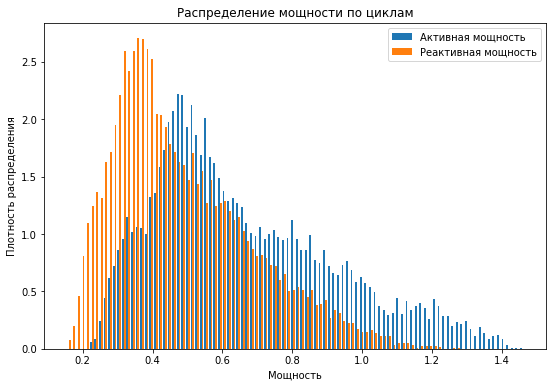

In [14]:
plt.figure(figsize=(9,6))
plt.hist(data_arc_new[['Активная мощность', 'Реактивная мощность']], bins=100, density = True)
plt.legend(['Активная мощность', 'Реактивная мощность'], fontsize=10)
plt.title('Распределение мощности по циклам')
plt.xlabel('Мощность')
plt.ylabel('Плотность распределения')
plt.show()

In [15]:
'Коэффициент корреляции:', data_arc_new.corr()

('Коэффициент корреляции:',
                           key  Активная мощность  Реактивная мощность
 key                  1.000000          -0.010218            -0.013179
 Активная мощность   -0.010218           1.000000             0.966382
 Реактивная мощность -0.013179           0.966382             1.000000)

**ВЫВОДЫ:** в таблице "данные об электродах" 14876 записей, пропусков и дубликатов нет, уникальных значений по ключу 3214. В колонке "Реактивная мощность" обнаружен выброс, строки по ключу с выбросом удалены. Обнаружена высокая корреляция между признакми Активная и Реактивная мощность, при обработке признаки будут объединены в один по физической формуле полной мощности. По признакам начала и конца нагрева выведем время нагрева в секундах, далее введем новый признак ЭНЕРГИЮ (перемножив полную мощность на время нагрева), все остальные удалим.

### Изучим датафрейм "результаты измерения температуры"

In [16]:
data_info(data_temp_new)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


'Пропусков:'

key                0
Время замера       0
Температура     3427
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3216

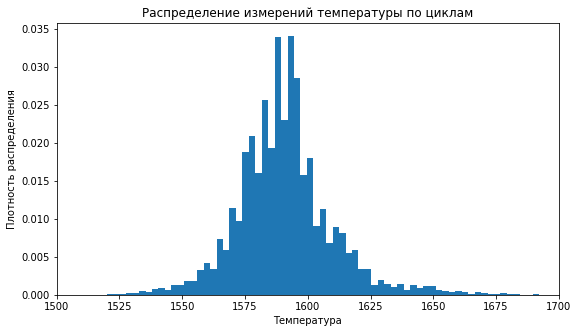

In [17]:
plt.figure(figsize=(9,5))
plt.hist(data_temp_new[['Температура']], bins=200, density = True)
plt.title('Распределение измерений температуры по циклам')
plt.xlabel('Температура')
plt.ylabel('Плотность распределения')
plt.xlim(1500, 1700)
plt.show()

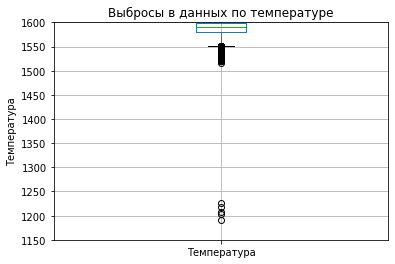

In [18]:
data_temp_new.boxplot(column='Температура') 
plt.ylabel('Температура')
plt.title('Выбросы в данных по температуре')
plt.ylim(1150, 1600)
plt.show()  

**ВЫВОДЫ:** в таблице "результаты измерения температуры" 18092 записи, дубликатов нет, 3427 пропусков в колонке "Температура" - при обработке надо будет удалить по ключу, уникальных значений по ключу 3216. В колонке "Температура" обнаружены выбросы со значением плавления при температуре ниже 1500 градусов, что явно является ошибочным (такие строки необходимо будет удалить по ключу). Таблица содержит измерения температуры с указанием времени на каждом цикле легирования для каждой партии. Последняя температура для каждой партии будет целевым признаком. Начальная температура будет использоваться как признак, промежуточные будут удалены, т.к. их использование будет "подглядыванием", что приведет к переобучению модели. Введем новый признак - время нагрева, так вычтем из времени замера конечной температуры время замера начальной.

### Изучим датафрейм "данные о продувке сплава газом"

In [19]:
data_info(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


'Пропусков:'

key      0
Газ 1    0
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3239

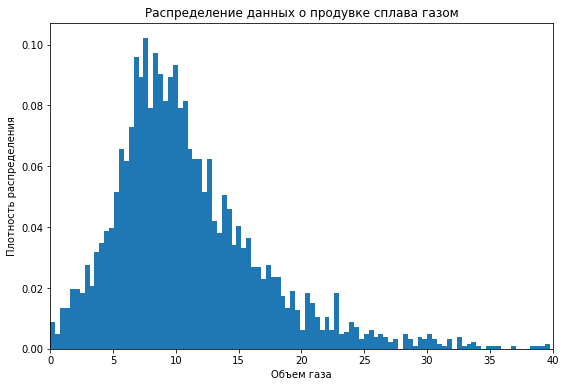

In [20]:
plt.figure(figsize=(9,6))
plt.hist(data_gas_new[['Газ 1']], bins=200, density = True)
plt.title('Распределение данных о продувке сплава газом')
plt.xlabel('Объем газа')
plt.ylabel('Плотность распределения')
plt.xlim(0, 40)
plt.show()

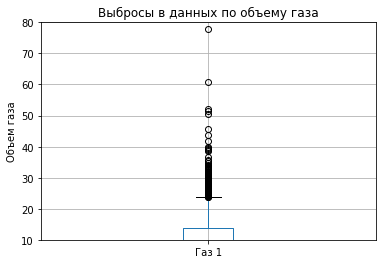

In [21]:
data_gas_new.boxplot(column='Газ 1') 
plt.ylabel('Объем газа')
plt.title('Выбросы в данных по объему газа')
plt.ylim(10, 80)
plt.show()

In [22]:
data_gas_new[data_gas_new['Газ 1'] > 40]

,key,Газ 1
116,117,50.581035
277,280,60.935689
319,322,77.995040
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
2107,2110,52.142373
2567,2570,51.380229


**ВЫВОД:** в таблице "данные о продувке сплава газом" 3239 записей, пропусков и дубликатов нет, уникальных значений по ключу 3239. В колонке "Газ 1" обнаружены выбросы. 

### Изучим датафрейм "данные о подаче сыпучих материалов (объём)"

In [23]:
data_info(data_bulk_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


'Пропусков:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3129

In [24]:
# создадим переменную суммарной концентрации по каждому ковшу
bulk = data_bulk_new[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 1','Bulk 15']].sum(axis=1)

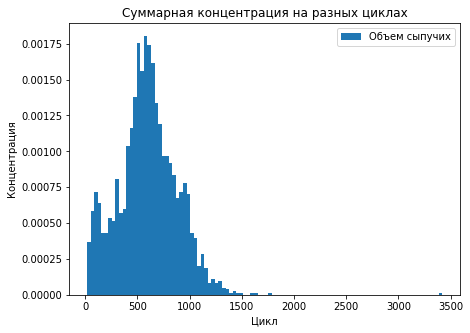

In [25]:
plt.figure(figsize=(7,5))
plt.hist(bulk, bins=100, density = True, label='Объем сыпучих')
plt.legend()
plt.title('Суммарная концентрация на разных циклах')
plt.xlabel('Цикл')
plt.ylabel('Концентрация')
plt.show()

**ВЫВОДЫ:** в таблице "данные о подаче сыпучих материалов (объём)" 3129 записей, дубликатов нет, пропусков очень много (указаные марки сыпучих не добавлялись в ковш) - при обработке необходимо заполнить нолями, уникальных значений по ключу 3129.  

### Изучим датафрейм "данные о подаче сыпучих материалов (время)"

In [26]:
data_info(data_bulk_time_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


'Пропусков:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3129

**ВЫВОДЫ:** таблица "данные о подаче сыпучих материалов (время)" содержит 3129 строк со временем добавления сыпучих материалов в процессе легирования, эту таблицу не будем использовать при построении модели, т.к. эти признаки никак не влияют на целевой признак - температуру.

### Изучим датафрейм "данные о проволочных материалах (объём)"

In [27]:
data_info(data_wire_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


'Пропусков:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3081

In [28]:
# создадим переменную суммарной концентрации по каждому ковшу
wire = data_wire_new[['Wire 1', 'Wire 2', 'Wire 3','Wire 4','Wire 5','Wire 6','Wire 7','Wire 8','Wire 9']].sum(axis=1)

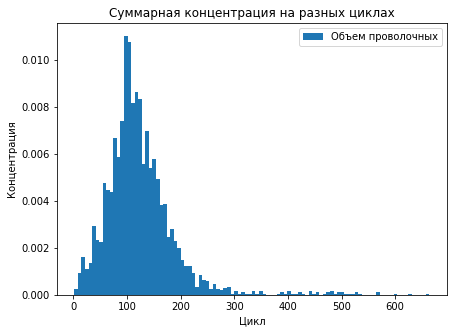

In [29]:
plt.figure(figsize=(7,5))
plt.hist(wire, bins=100, density = True, label='Объем проволочных')
plt.legend()
plt.title('Суммарная концентрация на разных циклах')
plt.xlabel('Цикл')
plt.ylabel('Концентрация')
plt.show()

**ВЫВОДЫ:** в таблице "данные о проволочных материалах (объём)" 3081 записей, дубликатов нет, пропусков очень много (указаные марки проволоки не добавлялись в ковш), при этом признаки Wire 4, Wire 5, Wire 7, Wire 8 и Wire 9 можно удалить полностью, т.к. в них заполнено значений от 1 до 29, остальные при обработке необходимо заполнить нолями, уникальных значений по ключу 3081. 

### Изучим датафрейм "данные о проволочных материалах (время)"

In [30]:
data_info(data_wire_time_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


'Пропусков:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

'Дубликатов:'

0

'Количество уникальных ключей:'

3081

**ВЫВОДЫ:** таблица "данные о проволочных материалах (время)" содержит 3081 строку со временем добавления проволочных материалов в процессе легирования, эту таблицу не будем использовать при построении модели, т.к. эти признаки никак не влияют на целевой признак - температуру.

**ОБЩИЕ ВЫВОДЫ ПО РАЗДЕЛУ:** Загрузили 7 файлов, по каждому датафрейму провели исследовательский анализ. Дубликатов в датафремах нет. Обнаруженные строки с пропусками по температуре при дальнейшей обработке удалим по ключу, остальные пропуски заполним 0. Обнаруженные строки с сильно выпадающими значениями в "Реактивной мощности" датафрейма об электродах (data_arc_new) и низкие (нереальные, ниже 1500С) температуры плавки в датафрейме измерения температуры (data_temp_new) удалим по ключу. Целевой признак - конечная температура нагрева - выведем в отдельный признак из датафрейма data_temp_new (результаты измерения температуры), из разницы данных по замеру времени начальной и конечной температуры этого же датафрейма введем новый признак "Время нагрева". Датафреймы о проволочных материалах (время) и о подаче сыпучих (время) не будем использовать при построении модели из-за отсутствия влияния на целевой признак. Добавим новый признак "Энергия" путем преобразования всех данных из датафрейма data_arc_new — данные об электродах, применив вычисления по физической формуле (так как обнаружена сильная корреляция между мощностями).

# ПЛАН

1.	Таблицы о проволочных материалах (время) и о подаче сыпучих (время) отбрасываем, т.к. время подачи не влияет на результат, нам важно время замера температуры

2.	Много пропусков в таблице о проволочных материалах (объем): столбцы “Wire 3”, “Wire 4” …“Wire 9” содержат ненулевые значения всего лишь в количестве строк от 1 до 73. Всего таких строк 164 из 3081 (всего 5%). Можно удалить ненужные признаки с большим количеством пропусков с Wire 3 по Wire 9 (это всего 5%), остальные пропуски заполнить нолями

3.	Много пропусков в таблице о подаче сыпучих (объем), заполнить нолями.

4.	Обработать выбросы и аномалии (удалить сильно выпадающие)

5.	Вводим дополнительный признак «Энергия» по физической формуле связи активной и реактивной (корень из суммы  квадратов) умноженной на время нагрева. Колонки начала и конца нагрева, активной и реактивной мощности удалим

6.	По таблице результатов измерения температуры отбираем в каждой партии конечную температуру как целевой признак, начальную температуру берем как признак, остальные промежуточные замеры удаляем, вводим признак время нагрева вычитанием времени между  конечным циклом и начальным

7.	Объединим в общую таблицу итоговые пять таблиц методом INNER, т.к. у нас в каждой таблице по колонке “key” разное количество уникальных значений

8.	Разделим на выборки и выделим целевой признак

9. Проводим масштабирование признаков

10.	Выберем метрику МАЕ, т.к. это регрессия и она более интерпретируемая для заказчика, и её значение проверим на двух моделях с подбором гиперпараметров и использованием кросс-валидации. МАЕ должна быть менее 6,8.

11. Проверим лучшую модель на тесте.

12. Исследуем важность признаков

13. Сравним с константой моделью


## Предобработка данных

### Датафрейм "данные об электродах"

In [31]:
# добавим новый признак "Время нагрева" в секундах
data_arc_new['Время нагрева'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.seconds

In [32]:
data_arc_new['Время нагрева'] 

0        228
1        185
2        172
3        365
4        148
        ... 
14871    157
14872    180
14873    184
14874     57
14875     81
Name: Время нагрева, Length: 14872, dtype: int64

**Вычислим полную мощность S:**

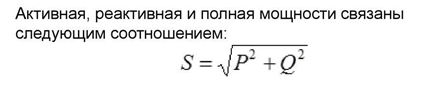

**Вычислим и добавим в качестве признака энергию, затраченную на нагрев, путем перемножения полной мощности на время нагрева**

In [33]:
data_arc_new['Энергия на нагрев'] = data_arc_new['Время нагрева'] * \
(data_arc_new['Активная мощность']**2 + data_arc_new['Реактивная мощность']**2)**0.5

In [34]:
# создадим таблицу с финальными признаками
data_arc_new = data_arc_new[['key','Энергия на нагрев']]

In [35]:
data_arc_new.head(6)

,key,Энергия на нагрев
0,1,84.616003
1,1,166.928978
2,1,124.276277
3,1,234.630603
4,1,159.830252
5,2,60.312695


In [36]:
# посчитаем количество циклов нагрева на каждый ключ, запишем его в датафрейм rounds
rounds = data_arc_new['key'].value_counts().reset_index(name='Количество циклов нагрева').rename(columns={'index': 'key'})

In [37]:
rounds.sort_values(by='key').head()

,key,Количество циклов нагрева
1405,1,5
1964,2,4
1394,3,5
2083,4,4
2452,5,4


In [38]:
# посчитаем общую энергию нагрева на каждый ключ
energy = data_arc_new.groupby(by = 'key').sum()

In [39]:
energy.head()

,Энергия на нагрев
key,
1,770.282114
2,481.760005
3,722.837668
4,683.455597
5,512.169934


In [40]:
# сольём две полученных таблицы по ключу
data_arc_new = energy.merge(rounds, on='key')

In [41]:
data_arc_new.head()

,key,Энергия на нагрев,Количество циклов нагрева
0,1,770.282114,5
1,2,481.760005,4
2,3,722.837668,5
3,4,683.455597,4
4,5,512.169934,4


In [42]:
data_arc_new.describe()

,key,Энергия на нагрев,Количество циклов нагрева
count,3213.000000,3213.000000,3213.000000
mean,1622.907874,655.688884,4.628696
std,934.844882,308.950188,1.608860
min,1.000000,33.430208,1.000000
25%,817.000000,444.864502,4.000000
50%,1623.000000,620.111140,4.000000
75%,2432.000000,827.784614,6.000000
max,3241.000000,4546.405812,16.000000


### Датафрейм "результаты измерения температуры"

In [43]:
# создадим список с ключами, в которых обнаружены пропуски
value = list(data_temp_new[data_temp_new['Температура'].isnull() == True]['key'].unique())

In [44]:
# удалим строки с пропусками по ключу
data_temp_new = data_temp_new.loc[data_temp_new['key'].isin(value) == False]

In [45]:
data_temp_new.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [46]:
# создадим список с ключами, в которых нереально низкие температуры плавления
value = list(data_temp_new[data_temp_new['Температура'] < 1450]['key'].unique())

In [47]:
# удалим низкие температуры по ключу
data_temp_new = data_temp_new.loc[data_temp_new['key'].isin(value) == False]

In [48]:
# посмотрим, есть ли записи с одним измерением температуры по ключу
data_temp_new.groupby('key').count().sort_values(by='Время замера').head()

,Время замера,Температура
key,,
279,1,1
195,1,1
614,2,2
1268,2,2
1974,2,2


In [49]:
# сгруппируем по ключу и присвоим количество циклов в каждом ключе переменной value
value = data_temp_new.groupby('key')['key'].count()

In [50]:
# создадим список с ключами, в которых количество циклов более одного
value = list(value[value !=1].index)

In [51]:
# удалим строки с еденичными измерениями по ключу
data_temp_new = data_temp_new.loc[data_temp_new['key'].isin(value)]

In [52]:
data_temp_new.head(7)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0


In [53]:
# агрегируем данные так, чтобы остались только первые и последние записи по ключу
data_temp_new = data_temp_new.groupby('key').agg(['first', 'last']).reset_index()

In [54]:
data_temp_new.head(7)

key        Время замера                     Температура        
                    first                last       first    last
0   1 2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0  1613.0
1   2 2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0  1602.0
2   3 2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0  1599.0
3   4 2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0  1625.0
4   5 2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0  1602.0
5   6 2019-05-03 13:46:41 2019-05-03 14:11:38      1543.0  1596.0
6   7 2019-05-03 14:16:36 2019-05-03 14:45:40      1586.0  1599.0

In [55]:
# переименуем столбцы
data_temp_new.columns = ['key', 'Начальное время', 'Конечное время', 'Первичная температура', 'Конечная температура']

In [56]:
# добавим новый признак - время нагрева в секундах
data_temp_new['Время нагрева'] = (data_temp_new['Конечное время'] - data_temp_new['Начальное время']).dt.seconds

In [57]:
# создадим таблицу с финальными признаками
data_temp_new = data_temp_new[['key','Первичная температура', 'Конечная температура', 'Время нагрева']]

In [58]:
data_temp_new.head(7)

,key,Первичная температура,Конечная температура,Время нагрева
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536
5,6,1543.0,1596.0,1497
6,7,1586.0,1599.0,1744


### Датафрейм "данные о продувке сплава газом"

Изменять данные в таблице по газу не нужно

### Датафрейм "данные о подаче сыпучих материалов (объём)"

In [59]:
# заполним пропуски нолями
data_wire_new = data_wire_new.fillna(0)

In [60]:
data_wire_new.head(7)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,99.109917,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,98.061600,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Датафрейм "данные о проволочных материалах (объём)"

In [61]:
# заполним пропуски нолями
data_bulk_new = data_bulk_new.fillna(0)

In [62]:
data_bulk_new.head(7)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
5,6,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0
6,7,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0


### Объеденим обработанные датафреймы

In [63]:
# объденим так, чтобы в итоговый датафрейм попали только такие строки, которые есть во всех пяти таблицах
data1 = data_temp_new.merge(data_arc_new, on='key', how='inner')
data2 = data_wire_new.merge(data_bulk_new, on='key', how='inner')
data3 = data_gas_new.merge(data2, on='key', how='inner')
data_final = data1.merge(data3, on='key', how='inner')

In [64]:
data_final.tail(7)

,key,Первичная температура,Конечная температура,Время нагрева,Энергия на нагрев,Количество циклов нагрева,Газ 1,Wire 1,Wire 2,Wire 3,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2317,2493,1599.0,1594.0,1863,433.996124,3,9.421691,122.172958,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,236.0,0.0,118.0,205.0
2318,2494,1585.0,1591.0,905,324.714465,3,3.983053,75.042236,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,155.0,0.0,119.0,155.0
2319,2495,1570.0,1591.0,1380,694.177326,4,7.125735,89.150879,0.00000,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2320,2496,1554.0,1591.0,1705,815.818538,6,9.412616,114.179527,0.00000,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2321,2497,1571.0,1589.0,962,823.020520,3,6.271699,94.086723,9.04800,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2322,2498,1591.0,1594.0,1520,581.810739,5,14.953657,118.110717,0.00000,0.0,...,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0
2323,2499,1569.0,1603.0,1537,532.386183,4,11.336151,110.160958,50.00528,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0


In [65]:
# удалим столбец с номером ключа, он не влияет на результат
data_final = data_final.drop('key', axis=1)

In [66]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Первичная температура      2324 non-null   float64
 1   Конечная температура       2324 non-null   float64
 2   Время нагрева              2324 non-null   int64  
 3   Энергия на нагрев          2324 non-null   float64
 4   Количество циклов нагрева  2324 non-null   int64  
 5   Газ 1                      2324 non-null   float64
 6   Wire 1                     2324 non-null   float64
 7   Wire 2                     2324 non-null   float64
 8   Wire 3                     2324 non-null   float64
 9   Wire 4                     2324 non-null   float64
 10  Wire 5                     2324 non-null   float64
 11  Wire 6                     2324 non-null   float64
 12  Wire 7                     2324 non-null   float64
 13  Wire 8                     2324 non-null   float

In [67]:
# проверим средние значения финальной таблицы (по столбцам с проволокой и сыпучими - самые заполненные столбцы)
round(data_final[['Первичная температура', 'Конечная температура', 'Время нагрева', 'Энергия на нагрев',\
                 'Количество циклов нагрева', 'Газ 1', 'Wire 1', 'Wire 2', 'Bulk 14', 'Bulk 15']].describe(),2)

,Первичная температура,Конечная температура,Время нагрева,Энергия на нагрев,Количество циклов нагрева,Газ 1,Wire 1,Wire 2,Bulk 14,Bulk 15
count,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00
mean,1587.37,1593.37,2323.68,670.23,4.70,11.38,102.42,17.61,153.95,120.08
std,23.63,11.21,1385.81,319.53,1.61,6.40,43.54,33.65,81.41,84.66
min,1519.00,1541.00,339.00,33.43,1.00,0.01,0.00,0.00,0.00,0.00
25%,1571.00,1587.00,1580.50,457.92,4.00,7.28,73.20,0.00,105.00,0.00
50%,1587.00,1593.00,2046.50,631.23,5.00,10.10,101.10,0.00,149.00,107.00
75%,1603.00,1598.00,2793.50,841.82,6.00,14.22,128.08,23.10,204.00,204.00
max,1660.00,1653.00,23674.00,4546.41,16.00,78.00,330.31,282.78,636.00,405.00


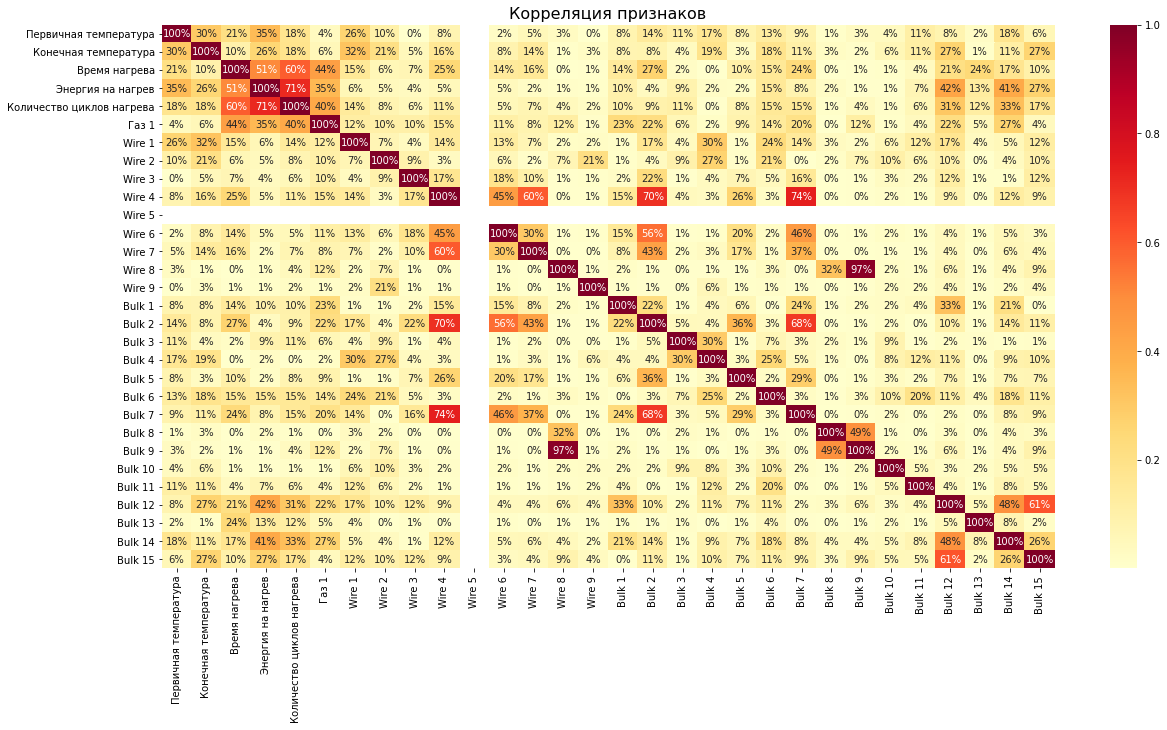

In [87]:
# посмотрим на корреляцию основных признаков
plt.figure(figsize=(20, 10))
fig = seaborn.heatmap(round(data_final, 2).corr().abs(), fmt='.0%', cmap='YlOrRd', annot=True)
plt.title('Корреляция признаков', fontsize=16)
#plt.setp(fig.get_xticklabels(), rotation=35)
plt.show()

In [88]:
# удалим столбец Bulk 9 из-за высокой корреляции с Wire 8
features = data_final.drop(['Bulk 9'], axis=1)

Бльше сильно кореллирующих признаков не выявлено.

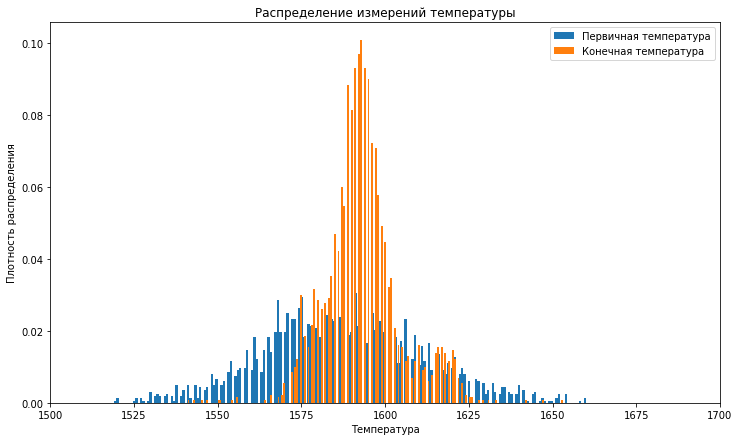

In [89]:
# исследуем распределение новых признаков температуры в итоговом датафрейме
plt.figure(figsize=(12,7))
plt.hist(data_final[['Первичная температура']], bins=200, density = True)
plt.hist(data_final[['Конечная температура']], bins=200, density = True)
plt.legend(['Первичная температура', 'Конечная температура'], fontsize=10)
plt.title('Распределение измерений температуры')
plt.xlabel('Температура')
plt.ylabel('Плотность распределения')
plt.xlim(1500, 1700)
plt.show()

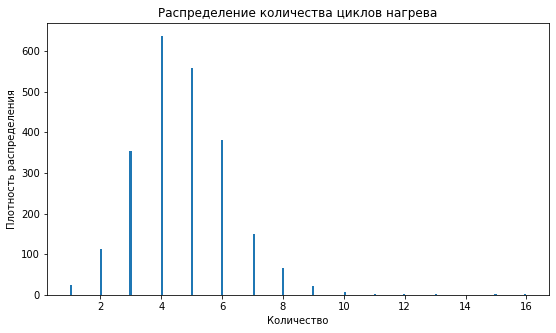

In [90]:
# исследуем распределение нового признака "Количество циклов нагрева" в итоговом датафрейме
plt.figure(figsize=(9,5))
plt.hist(data_final[['Количество циклов нагрева']], bins=200)
plt.title('Распределение количества циклов нагрева')
plt.xlabel('Количество')
plt.ylabel('Плотность распределения')
plt.xlim()
plt.show()

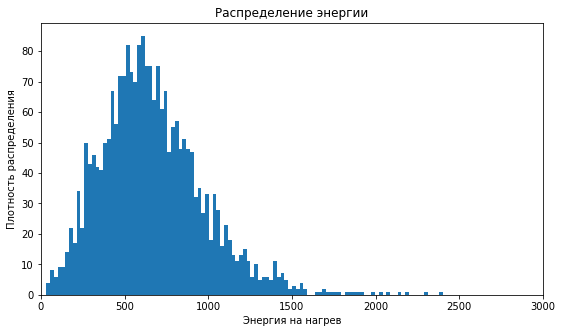

In [91]:
# исследуем распределение нового признака "Энергия на нагрев" в итоговом датафрейме
plt.figure(figsize=(9,5))
plt.hist(data_final[['Энергия на нагрев']], bins=200)
plt.title('Распределение энергии')
plt.xlabel('Энергия на нагрев')
plt.ylabel('Плотность распределения')
plt.xlim(0,3000)
plt.show()

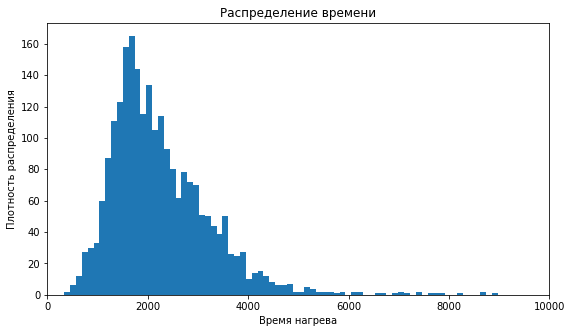

In [92]:
# исследуем распределение нового признака "Время нагрева" в итоговом датафрейме
plt.figure(figsize=(9,5))
plt.hist(data_final[['Время нагрева']], bins=200)
plt.title('Распределение времени')
plt.xlabel('Время нагрева')
plt.ylabel('Плотность распределения')
plt.xlim(0, 10000)
plt.show()

**ВЫВОД:** Мы провели предобработку данных, ввели новые признаки, удалили ненужные, объеденили пять таблиц по пересечению ключей. Признак, который нужно предсказать, — целевой: в нашей задаче это - Конечная температура. Такие задачи относятся к классу «обучение с учителем». Целевой признак числовой, т.о. мы будем решать задачу регрессии. Метрику выберем МАЕ, т.к. она более интерпретируема для заказчика.

##   Обучим разные модели и оценим их качество кросс-валидацией.

### Подготовим данные

In [93]:
random = 280823

In [94]:
# выделим признаки
features = data_final.drop(['Конечная температура'], axis=1)
target = data_final['Конечная температура']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=random)

### Модель LGBMRegressor

In [95]:
# используем конвейер, чтобы обучение кодировщика при кросс-валидации производилось только на фолдах в состоянии обучения
lg_mpipe = make_pipeline(StandardScaler(), LGBMRegressor(random_state=random))
lg_mpipe.steps[1]

('lgbmregressor', LGBMRegressor(random_state=280823))

In [96]:
%%time
# используем поиск по сетке GridSearchCV для оптимизации гиперпараметров
params_lg = {
    'lgbmregressor__n_estimators': range(60, 70, 10),
    'lgbmregressor__boosting_type': ['gbdt', 'dart']   
}

lg_gscv = GridSearchCV(
    lg_mpipe,
    params_lg,
    scoring='neg_mean_absolute_error',
    cv=3,   # количество блоков для кросс-валидации
    verbose=3  # видеть время
)

lg_gscv.fit(X_train, y_train)

print(f'Лучша оценка LGBMрегрессии: {(-1)*round(lg_gscv.best_score_, 3)}')

print(f'Лучшие гиперпараметры LGBMрегрессии: {lg_gscv.best_params_}')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END lgbmregressor__boosting_type=gbdt, lgbmregressor__n_estimators=60; total time= 3.5min
[CV 2/3] END lgbmregressor__boosting_type=gbdt, lgbmregressor__n_estimators=60; total time= 3.4min
[CV 3/3] END lgbmregressor__boosting_type=gbdt, lgbmregressor__n_estimators=60; total time= 3.4min
[CV 1/3] END lgbmregressor__boosting_type=dart, lgbmregressor__n_estimators=60; total time= 3.4min
[CV 2/3] END lgbmregressor__boosting_type=dart, lgbmregressor__n_estimators=60; total time= 3.4min
[CV 3/3] END lgbmregressor__boosting_type=dart, lgbmregressor__n_estimators=60; total time= 4.0min
Лучша оценка LGBMрегрессии: 6.317
Лучшие гиперпараметры LGBMрегрессии: {'lgbmregressor__boosting_type': 'gbdt', 'lgbmregressor__n_estimators': 60}
CPU times: user 24min 13s, sys: 10.6 s, total: 24min 23s
Wall time: 24min 37s


### Модель CatBoostRegressor

In [97]:
# используем конвейер
cat_br = make_pipeline(StandardScaler(), CatBoostRegressor(random_state=random))
cat_br.steps[1]

('catboostregressor', <catboost.core.CatBoostRegressor at 0x7f0b22529130>)

In [98]:
%%time
# используем поиск по сетке GridSearchCV
params_cat = {
    'catboostregressor__iterations': range(70, 100, 5),
    'catboostregressor__learning_rate': [0.1],
    'catboostregressor__depth': range(4, 8, 2)
}

cat_gscv = GridSearchCV(
    cat_br,
    params_cat,
    scoring='neg_mean_absolute_error',
    cv=3,   # количество блоков для кросс-валидации
    verbose=3  # видеть время
)

cat_gscv.fit(X_train, y_train)

print(f'Лучша оценка CatBoostрегрессии: {(-1)*round(cat_gscv.best_score_, 2)}')

print(f'Лучшие гиперпараметры CatBoostрегрессии: {cat_gscv.best_params_}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
0:	learn: 10.7966374	total: 47.7ms	remaining: 3.29s
1:	learn: 10.5390590	total: 49.1ms	remaining: 1.67s
2:	learn: 10.3392416	total: 50.5ms	remaining: 1.13s
3:	learn: 10.1827649	total: 51.8ms	remaining: 855ms
4:	learn: 10.0251208	total: 53.2ms	remaining: 691ms
5:	learn: 9.8828630	total: 54.4ms	remaining: 581ms
6:	learn: 9.7714435	total: 55.7ms	remaining: 501ms
7:	learn: 9.6504348	total: 57ms	remaining: 442ms
8:	learn: 9.5691932	total: 58.6ms	remaining: 397ms
9:	learn: 9.4433944	total: 60.4ms	remaining: 363ms
10:	learn: 9.3464270	total: 62.1ms	remaining: 333ms
11:	learn: 9.2463903	total: 63.4ms	remaining: 307ms
12:	learn: 9.1667452	total: 64.8ms	remaining: 284ms
13:	learn: 9.1179896	total: 66ms	remaining: 264ms
14:	learn: 9.0586286	total: 67.4ms	remaining: 247ms
15:	learn: 9.0113959	total: 68.6ms	remaining: 231ms
16:	learn: 8.9555304	total: 69.8ms	remaining: 217ms
17:	learn: 8.9149535	total: 71ms	remaining: 205ms
18:	learn: 8.8

### Выберем лучшую модель, посчитаем оценку на тестовой выборке и выведем важность признаков.

**Лучшие результаты показала модель CatBoostRegressor с глубиной 6 и количеством деревьев 95**

In [99]:
predict = cat_gscv.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, predict)
mae

6.6688419928179155

На тестовой выборке MAE равно 6.6688419928179155, что соответсвует критерию успешности сдачи проекта в размере не превышающем 6,8.

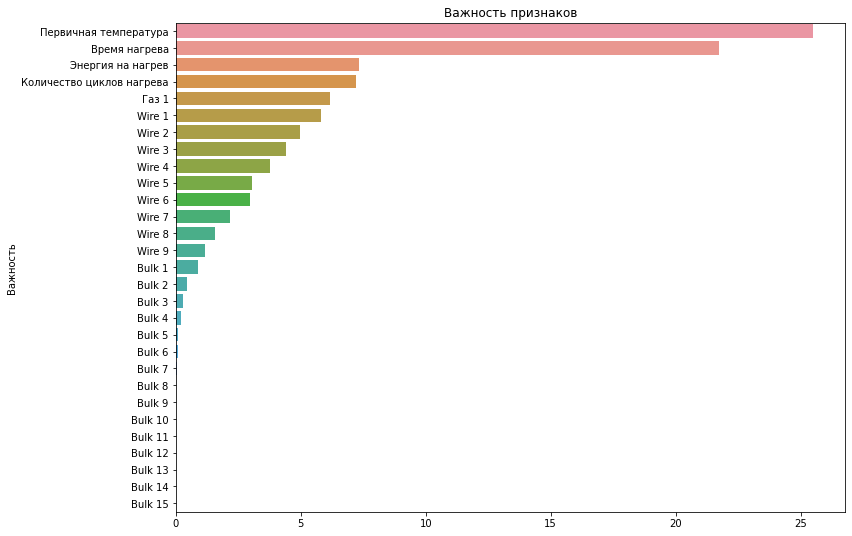

In [100]:
# посмотрим на важность признаков
feature_importances = cat_gscv.best_estimator_._final_estimator.feature_importances_
important = pd.Series(feature_importances, X_test.columns)
important = important.sort_values(ascending=False)
fig, az = plt.subplots(figsize=(12,9))
seaborn.barplot(x=important, y=X_test.columns)
#important.plot.bar(ax=az)
az.set_title('Важность признаков')
az.set_ylabel('Важность');

Самые важные признаки: первичная температура и, созданный нами признак, время нагрева, а в тройку вошел признак - энергия на нагрев.

### Проверим модель на адекватность с помощью фиктивной модели DummyRegressor

In [101]:
model_d = DummyRegressor()
model_d.fit(X_train, y_train)
predictions = model_d.predict(X_test)

result = mean_absolute_error(y_test, predictions)

print('Итоговая MAE:', result)

Итоговая MAE: 8.258009663438608


Итоговая MAE у нашей регрессии лучше чем у модели, которая предсказывает всегда среднее значения. Таким образом, делаем вывод, что наша модель адекватна.



**ОБЩИЙ ВЫВОД: Чтобы оптимизировать производственные расходы для металлургического комбината ООО «Так закаляем сталь» по уменьшению потребления электроэнергии на этапе обработки стали мы построили модель, которая предскажет температуру стали. Мы изучили данные из семи таблиц, там где было необходимо избавились от выбросов, заменили пропуски, создали новые признаки. По результатам предобработки объеденили только нужные датафреймы в один, выделили целевой признак, разделили данные. Исследовали качество разных моделей с градиентным бустингом, приводя числовые признаки к одному масштабу, меняя гиперпараметры, испрользуя паплайн. Из использованных моделей: CatBoostRegressor(), LGBMRegressor(), лучший результат показала модель - CatBoostRegressor() с depth=6, iterations=95. При проверке качества модели на тестовой выборке мы получили mae  6.6688419928179155**

## Отчет

### Выполнение плана

Выполнили все пункты плана, но удалять признаки с большим колличеством пропусков не стали, чтобы не ухудшать метрику. Обнаружили сильную корреляцию признаков Bulk 9 и Wire 8, поэтому Bulk 9 удалили.

### Описание трудностей проекта

Метрика на тесте получалась выше 6.8, пришлось для улучшения метрики добавить еще один признак - Количество циклов нагрева.

### Описание ключевых шагов решения:

#### Исследовательский анализ и предобработка данных

Изучили данные из семи таблиц, две из них с датами о проволочных материалах (время) и о подаче сыпучих (время) исключили из проекта. 

Строки с пропусками по температуре удалили по ключу, остальные заполнили 0. Строки с реактивной мощностью менее 0 датафрейма об электродах (data_arc_new) и нереально низкие, ниже 1500С, температуры плавки в датафрейме измерения температуры (data_temp_new) удалили по ключу. 

Ввели новые признаки "Энергия на нагрев" (по физической формуле энергии), "Количество циклов нагрева", "Время нагрева", конечная и начальная температура нагрева. Признаки, которые использовали для создания новых удалали.  

#### Подготовка данных

Обработанные таблицы склеили по ключу методом пересечения данных. Получили таблицу из 2324 строк и 29 столбцов. Удалили после объединения столбец с ключём.

Итоговые признаки: 'Первичная температура', 'Конечная температура', 'Время нагрева', 'Энергия на нагрев', 'Количество циклов нагрева', 'Газ 1', 'Wire 1'... 'Wire 9', 'Bulk 1' ... 'Bulk 15' (Bulk 9 удалили). 

#### Обучение модели

Исследовали качество двуз разных моделей с градиентным бустингом CatBoostRegressor() и LGBMRegressor()

Масштабирование провели используя паплайн скейлером StandardScaler() с random_state=280823. 

Обучили модели с подбором гиперпараметров по сетке GridSearchCV на трех блоках для кросс-валидации:
- CatBoostRegressor() с параметрами iterations: range(70, 100, 5), learning_rate: 0.1, depth: range(4, 8, 2), 
- BMRegressor() с параметрами n_estimators: range(60, 70, 10), boosting_type: 'gbdt', 'dart'.  

#### Тестирование модели

Лучший результат показала модель - CatBoostRegressor() с depth=6, iterations=95.

При проверке качества модели на тестовой выборке мы получили mae 6.6688419928179155, что ниже, чем на фиктивной модели DummyRegressor() в 8.25. 

Самые важные признаки: первичная температура и, созданный нами признак, время нагрева.

### Рекомендации по улучшению решения  

Можно для улучшения метрки попробовать другой скейлер, или при обработке на локальном компьютере можно увеличить разбег гиперпараметров, что значительно увеличит время обработки, но поможет улучшить метрику. Также можно избавиться от аномалий в обучающей выборке.